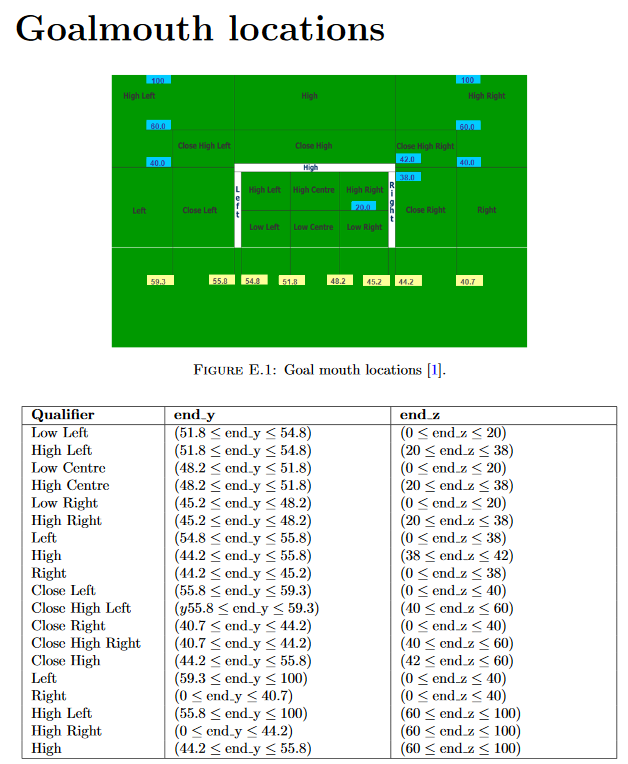
From https://pure.tue.nl/ws/portalfiles/portal/47028874/797423-1.pdf

Data files available at https://drive.google.com/drive/folders/1LhW3wcG5uoAAHcgPHRcJYmIQaMY9GlRI?usp=sharing

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from data_viz_helpers import *

In [2]:
def valid_shot(event):
    
    if event['type']['displayName']=='SavedShot':
        # Ignore blocked shots
        for qual in event['qualifiers']:
            if qual['type']['displayName'] == 'Blocked':
                return False
        return True
    
    elif event['type']['displayName']=='Goal':
        return True
    
    elif event['type']['displayName']=='MissedShots':
        z, y = event['goalMouthZ'], event['goalMouthY']
        return (z<=38) and (y>=45.2) and (y<=54.8)
    
    elif event['type']['displayName']=='ShotOnPost':
        z, y = event['goalMouthZ'], event['goalMouthY']
        return (z<=38) and (y>=45.2) and (y<=54.8)

# Load data and parse out valid shots on target

In [3]:
df = pd.DataFrame(columns=['z', 'y', 'goal'])
shots = list()

for filename in ['EPL_2018_match_data.json', 'EPL_2019_match_data.json', 'EPL_2020_match_data.json',
                 'EPL_2021_match_data.json', 'Bundesliga_2010_match_data.json']:
    # Read data from JSON file
    with open(filename, 'r') as f:
        data = json.loads(f.read())
    
    # Parse out shots on target
    for item in data.items():
        for event in item[1]['matchCentreData']['events']:
            try:
                valid = valid_shot(event)
            except:
                continue
            if valid:
#                 print(json.dumps(event, indent=2))
                shots.append(event)
                new_row = pd.Series(dtype='float')
                new_row['z'] = event['goalMouthZ']
                new_row['y'] = event['goalMouthY']
                new_row['goal'] = int(event['type']['displayName']=='Goal')
                df = df.append(new_row, ignore_index=True)
    print('Loaded {}, {} valid shots found so far'.format(filename, df.shape[0]))

Loaded EPL_2018_match_data.json, df has shape (3138, 5)
Loaded EPL_2019_match_data.json, df has shape (6413, 5)
Loaded EPL_2020_match_data.json, df has shape (9651, 5)
Loaded EPL_2021_match_data.json, df has shape (12901, 5)
Loaded Bundesliga_2010_match_data.json, df has shape (15736, 5)


# Shot locations

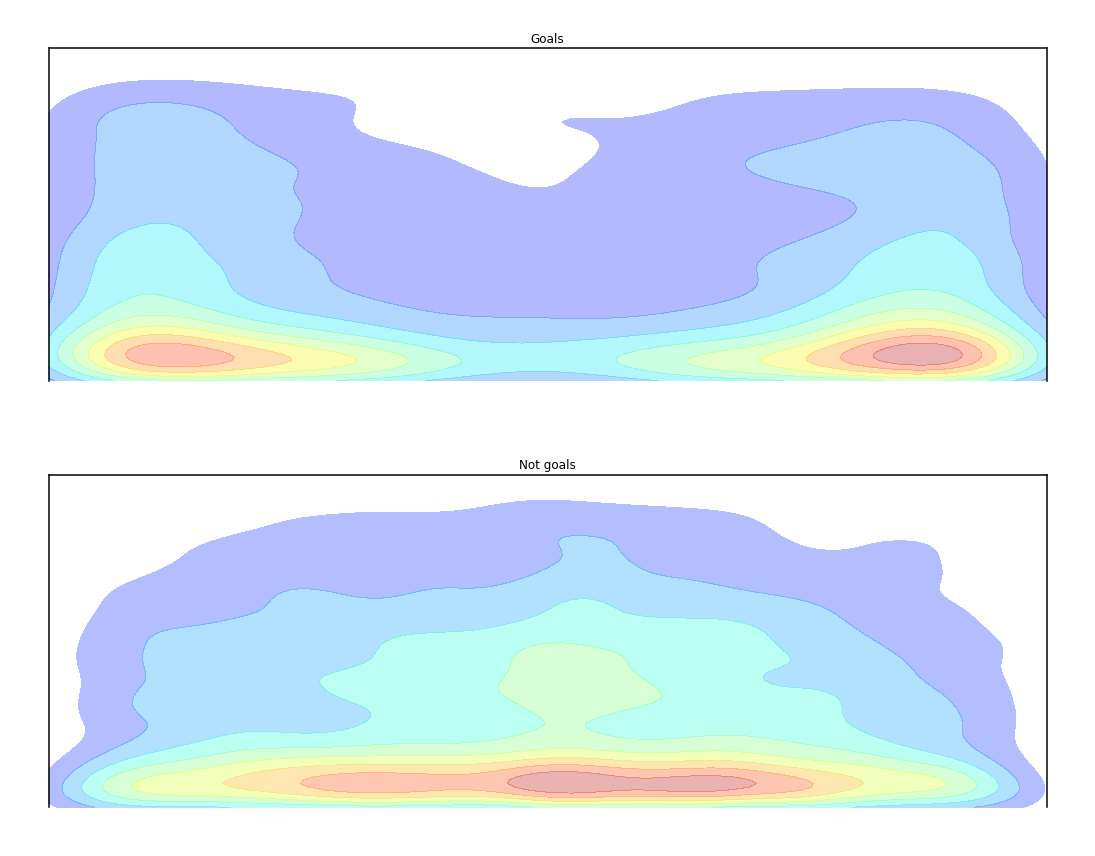

In [4]:
fig, ax = plt.subplots(figsize=[16,12], nrows=2, ncols=1)

# plot goalmouths
ax[0] = plot_goalmouth(ax[0])
ax[1] = plot_goalmouth(ax[1])

# plot goals
z = df[df['goal']==1]['z']/38*8
y = (df[df['goal']==1]['y']-45.2)/(54.8-45.2)*24
sns.kdeplot(y, z, ax=ax[0], shade=True, shade_lowest=False, cmap='jet', alpha=0.3, clip=[[0,24],[0,8]])
ax[0].set_xlim([-1, 25])
ax[0].set_ylim([-1, 9])
ax[0].set_title('Goals', y=0.9)

# plot not goals
z = df[df['goal']==0]['z']/38*8
y = (df[df['goal']==0]['y']-45.2)/(54.8-45.2)*24
sns.kdeplot(y, z, ax=ax[1], shade=True, shade_lowest=False, cmap='jet', alpha=0.3, clip=[[0,24],[0,8]])
ax[1].set_xlim([-1, 25])
ax[1].set_ylim([-1, 9])
ax[1].set_title('Not goals', y=0.9)

fig.tight_layout()
plt.show()

# Probability based on goalmouth location

In [14]:
z = df['z']/38*8
y = (df['y']-45.2)/(54.8-45.2)*24

stepsize = 0.25
prob_df = pd.DataFrame(columns=['h', 'v', 'p'])
for i in np.arange(0, 24, stepsize):
    for j in np.arange(0, 8, stepsize):
        # find shots in the current square
        horizontal = np.logical_and(y>=i, y<(i+stepsize))
        vertical = np.logical_and(z>=j, z<(j+stepsize))
        in_square = df.loc[np.where(np.logical_and(horizontal, vertical))[0], :]
        # determine if shots were goals or not
        goals = in_square[in_square['goal']==1].shape[0]
        not_goals = in_square[in_square['goal']==0].shape[1]
        # add to df
        new_row = pd.Series(dtype='object')
        new_row['h'] = i
        new_row['v'] = j
        new_row['p'] = goals / (goals+not_goals)
        prob_df = prob_df.append(new_row, ignore_index=True)

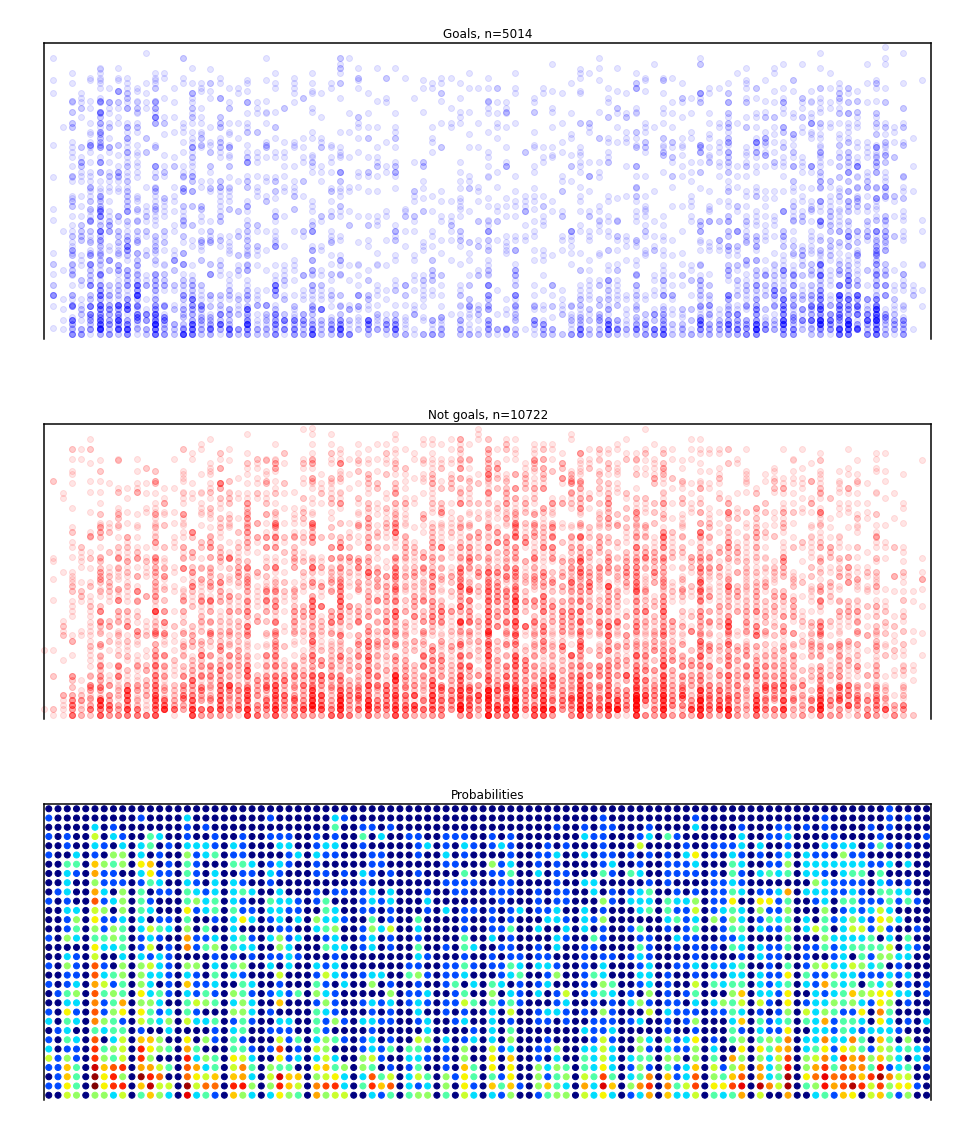

In [15]:
fig, ax = plt.subplots(figsize=[16,16], nrows=3, ncols=1)

# plot goalmouths
ax[0] = plot_goalmouth(ax[0])
ax[1] = plot_goalmouth(ax[1])
ax[2] = plot_goalmouth(ax[2])

# plot goals
z = df[df['goal']==1]['z']/38*8
y = (df[df['goal']==1]['y']-45.2)/(54.8-45.2)*24
ax[0].scatter(y, z, alpha=0.1, color='blue')
ax[0].set_xlim([-1, 25])
ax[0].set_ylim([-1, 9])
ax[0].set_title('Goals, n={}'.format(df[df['goal']==1].shape[0]), y=0.9)

# plot not goals
z = df[df['goal']==0]['z']/38*8
y = (df[df['goal']==0]['y']-45.2)/(54.8-45.2)*24
ax[1].scatter(y, z, alpha=0.1, color='red')
ax[1].set_xlim([-1, 25])
ax[1].set_ylim([-1, 9])
ax[1].set_title('Not goals, n={}'.format(df[df['goal']==0].shape[0]), y=0.9)

# plot probabilities
ax[2].scatter(x=prob_df['h']+stepsize/2, y=prob_df['v']+stepsize/2, c=prob_df['p'], cmap='jet')
ax[2].set_xlim([-1, 25])
ax[2].set_ylim([-1, 9])
ax[2].set_title('Probabilities', y=0.9)

fig.tight_layout()
plt.show()